# 0. Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import warnings

# Filter out the specific UserWarnings
warnings.filterwarnings("ignore", category=UserWarning, message="A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy")
warnings.filterwarnings("ignore", category=UserWarning, message="unable to load libtensorflow_io_plugins.so")
warnings.filterwarnings("ignore", category=UserWarning, message="file system plugins are not loaded")

In [3]:
# Hugging Face library
from transformers import AutoTokenizer, TFAutoModel, TFAutoModelForSequenceClassification

In [4]:
# Hugging Face library
from datasets import Dataset, DatasetDict

In [5]:
# Accuracy metrics and model selection from Scikit-Learn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

from sklearn.model_selection import train_test_split

In [6]:
import tensorflow as tf

from tensorflow.keras.optimizers import AdamW


from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras.layers import Input, Dense

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

from tensorflow.keras.metrics import SparseCategoricalAccuracy

# 1. Load Dataset

In [7]:
# Create a function to import the data from xlxs format

def load_data(file_path):
    return pd.read_excel(file_path, header=None,names = ['ID','DATE','CHANNEL','text','sentiment','emotion','info'], skiprows=1)

df_path = '/kaggle/input/peaks-sentiment-emotion/Peaks_sentiment_emotion.xlsx'

df = load_data(df_path)

In [8]:
pd.set_option('display.max_colwidth', 150)
df.head()

,ID,DATE,CHANNEL,text,sentiment,emotion,info
0,cdec5aa6fae29c87d2f736322cfe70c2,2020-06-11T00:00:00Z,FEED,"Ministro Speranza: ""l'alienazione parentale è un problema relazionale Genitore-figlio come come ci Ministro della Salute Roberto Speranza.X CLOSEM...",-,-,-
1,fc3f6327b8e2840a1bf798e5c89ddf93,2020-06-11T00:00:00Z,FEED,"""Esce con l'amante"". Uccide l'ex moglie ma lei andava a curarsi - IlGiornale.it ""Esce con l'amante"". Uccide l'ex moglie ma lei andava a curarsiPri...",-,-,-
2,d4d2b0342f900b9092651d5662fdabe6,2020-06-11T00:00:00Z,FEED,"Civita di Bagnoregio, ingresso gratuito per medici e infermieri | Viterbo Post Home Tempo libero Civita di Bagnoregio, ingresso gratuito per medic...",-,-,-
3,c57ccff390c3035163513431b48f1c7b,2020-06-11T00:00:00Z,FEED,"PIPER CLUB apre virtualmente con Mix Video Show – Dea Notizie 11 Giugno 2020Non la classica diretta improntata su un singolo artista, quella ideat...",-,-,-
4,d4d71c15c8056f482ad54743842005a6,2020-06-11T00:00:00Z,FEED,"Cei: Omofobia, non serve una legge . Zan: Critiche a un testo su cui stiamo ancora lavorando - GAYNEWS Dopo l'intervento di ieri del vescovo di...",-,-,-


In [9]:
df = df[~((df['sentiment'] == 'UNPREDICTABLE') | (df['emotion'] == 'UNPREDICTABLE'))]

df = df[(df['sentiment'] != ' - ') & (df['emotion'] != ' - ') & (df['info'] != ' - ')]

df.reset_index(drop=True, inplace=True)

In [10]:
# Remove rows with NaN values
df = df.dropna()

In [11]:
# Check whether there are duplicates in the dataframe

print(df.shape)

duplicates = df.duplicated()

duplicate_count = duplicates.value_counts()
print(duplicate_count)

duplicate_lines = df[duplicates].index
for line in duplicate_lines:
    print(f"Duplicate row at line {line}:")
    print(df.loc[line])

df = df.drop_duplicates()

print(df.shape)

(26687, 7)
False    26687
dtype: int64
(26687, 7)


In [12]:
df.head()

,ID,DATE,CHANNEL,text,sentiment,emotion,info
0,2329826420178307312,1591956974000,INSTAGRAM,"VIERNES A LAS 18:30La esperada desescalada del confinamiento por fin está llegando, probablemente la mayoría de las personas no pensaron que el es...",NEG,TRISTEZZA,UNPREDICTABLE
1,2330062820655731480,1591985155000,INSTAGRAM,Worth the rain #fishing #carpfishing #carp #stalking #parklakes #parklakefishing #urbanfishing #angling #commoncarp,NEU,RABBIA,INFO
2,2329983078223164538,1591975649000,INSTAGRAM,#esprit migrateur #chevreuils #eatmeat #chasse #chassejusquaubout #hunt #hunter #hawke #bbq #approche #stalking #jaitoutmangé,POS,RABBIA,INFO
3,2329949009885948705,1591971587000,INSTAGRAM,Morning briefing then on the bus! #fieldsportsphotographer #fieldsportsphotography #fieldsports #inthefield #shootingtimes #shooting #hunting #sta...,POS,RABBIA,INFO
4,2330154666368548671,1591996104000,INSTAGRAM,-sii sempre te stessa! 🌊✨.....ᴄᴏᴍᴇ ᴀᴠᴇʀᴇ ʟᴀ ᴠᴏꜱᴛʀᴀ ᴅᴇᴅɪᴄᴀ ᴘᴇʀꜱᴏɴᴀʟɪᴢᴢᴀᴛᴀ:1.seguite questa page2.scriveteci in direct il tipo di dedica che desider...,POS,GIOIA,NOINFO


## 1.1 Distribution of the main features (EMOTION, SENTIMENT, INFO)

In [13]:
emotion_count = (df['emotion'].value_counts())
print(emotion_count)

NEUTRA       9296
RABBIA       7097
TRISTEZZA    6372
GIOIA        1337
SORPRESA     1335
AMORE        1184
PAURA          66
Name: emotion, dtype: int64


In [14]:
sentiment_count = (df['sentiment'].value_counts())
print(sentiment_count)

NEG    12552
POS     7756
NEU     6379
Name: sentiment, dtype: int64


In [15]:
info_count = (df['info'].value_counts(normalize=True)*100).round(2)
print(info_count)

NOINFO           47.94
INFO             42.32
UNPREDICTABLE     9.74
Name: info, dtype: float64


## 1.2 Preparing datasets

In [16]:
# Since I'm gonna use the sparse categorical cross entropy loss, I map the labels to integers

encoded_dict_emotion = {'TRISTEZZA':0, 'GIOIA':1, 'AMORE':2, 'RABBIA':3, 'PAURA':4, 'SORPRESA':5, 'NEUTRA':6}

df['emotion_label'] = df['emotion'].apply(lambda x:encoded_dict_emotion[x])

def label2id_emotion(label):
    if isinstance(label, list):
        return [encoded_dict_emotion[label] for label in label]
    else:
        return encoded_dict_emotion[label]
    
def id2label_emotion(id):
    encoded_dict_inv_emotion = {v: k for k, v in encoded_dict_emotion.items()}
    
    if isinstance(id, list):
        return [encoded_dict_inv_emotion[i] for i in id]
    else:
        return encoded_dict_inv_emotion[id]

In [17]:
encoded_dict_sentiment = {'NEG':0, 'NEU':1, 'POS':2}

df['sentiment_label'] = df['sentiment'].apply(lambda x:encoded_dict_sentiment[x])

def label2id_sentiment(label):
    if isinstance(label, list):
        return [encoded_dict_sentiment[label] for label in label]
    else:
        return encoded_dict_sentiment[label]

def id2label_sentiment(id):
    encoded_dict_inv_sentiment = {v: k for k, v in encoded_dict_sentiment.items()}
    
    if isinstance(id, list):
        return [encoded_dict_inv_sentiment[i] for i in id]
    else:
        return encoded_dict_inv_sentiment[id]

In [18]:
encoded_dict_info = {'INFO':0, 'NOINFO':1, 'UNPREDICTABLE':2}

df['info_label'] = df['info'].apply(lambda x:encoded_dict_info[x])

def label2id_info(label):
    if isinstance(label, list):
        return [encoded_dict_info[label] for label in label]
    else:
        return encoded_dict_info[label]

def id2label_info(id):
    encoded_dict_inv_info = {v: k for k, v in encoded_dict_info.items()}
    
    if isinstance(id, list):
        return [encoded_dict_inv_info[i] for i in id]
    else:
        return encoded_dict_inv_info[id]

## 1.3 Train, Validation, Test split

In [19]:
df_train, df_testval = train_test_split(df, test_size=0.25)

df_test, df_val = train_test_split(df_testval, test_size=0.2)

In [20]:
print("Dimension of train dataset is:", df_train.shape)
print("Dimension of validation dataset is:", df_val.shape)
print("Dimension of test dataset is:", df_test.shape)

Dimension of train dataset is: (20015, 10)
Dimension of validation dataset is: (1335, 10)
Dimension of test dataset is: (5337, 10)


In [21]:
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)
val_dataset = Dataset.from_pandas(df_val)

# Create the DatasetDict
dataset = DatasetDict({'train': train_dataset, 'test': test_dataset, 'validation': val_dataset})

print(dataset)

DatasetDict({
    train: Dataset({
        features: ['ID', 'DATE', 'CHANNEL', 'text', 'sentiment', 'emotion', 'info', 'emotion_label', 'sentiment_label', 'info_label', '__index_level_0__'],
        num_rows: 20015
    })
    test: Dataset({
        features: ['ID', 'DATE', 'CHANNEL', 'text', 'sentiment', 'emotion', 'info', 'emotion_label', 'sentiment_label', 'info_label', '__index_level_0__'],
        num_rows: 5337
    })
    validation: Dataset({
        features: ['ID', 'DATE', 'CHANNEL', 'text', 'sentiment', 'emotion', 'info', 'emotion_label', 'sentiment_label', 'info_label', '__index_level_0__'],
        num_rows: 1335
    })
})


# 2. Preprocess data

In [22]:
bert = TFAutoModel.from_pretrained('osiria/bert-tweet-base-italian-uncased', from_pt=True)
tokenizer = AutoTokenizer.from_pretrained('osiria/bert-tweet-base-italian-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['bert.encoder.layer.4.attention.self.distance_embedding.weight', 'bert.encoder.layer.2.attention.self.distance_embedding.weight', 'bert.encoder.layer.5.attention.self.distance_embedding.weight', 'bert.encoder.layer.3.attention.self.distance_embedding.weight', 'bert.encoder.layer.8.attention.self.distance_embedding.weight', 'bert.encoder.layer.11.attention.self.distance_embedding.weight', 'cls.predictions.decoder.weight', 'bert.encoder.layer.10.attention.self.distance_embedding.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'bert.encoder.layer.6.attention.self.distance_embedding.weight', 'bert.encoder.layer.9.attention.self.distance_embedding.weight', 'bert.encoder.layer.1.attention.self.distance_embedding.weight', 'cls.predictions.transform.dense.bias', 'bert.encoder.layer.0.attention

In [23]:
max_length = 256

def tokenize_text(dataset):
    return tokenizer(
        text=dataset['text'],
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf',
        verbose=True
    )

#  return_token_type_ids=False,

In [24]:
encoded_dataset = dataset.map(tokenize_text)
encoded_dataset

  0%|          | 0/20015 [00:00<?, ?ex/s]

  0%|          | 0/5337 [00:00<?, ?ex/s]

  0%|          | 0/1335 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['ID', 'DATE', 'CHANNEL', 'text', 'sentiment', 'emotion', 'info', 'emotion_label', 'sentiment_label', 'info_label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 20015
    })
    test: Dataset({
        features: ['ID', 'DATE', 'CHANNEL', 'text', 'sentiment', 'emotion', 'info', 'emotion_label', 'sentiment_label', 'info_label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5337
    })
    validation: Dataset({
        features: ['ID', 'DATE', 'CHANNEL', 'text', 'sentiment', 'emotion', 'info', 'emotion_label', 'sentiment_label', 'info_label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1335
    })
})

In [25]:
encoded_dataset = encoded_dataset.remove_columns(['sentiment','emotion','text','info','ID','DATE','CHANNEL','__index_level_0__','token_type_ids'])

encoded_dataset

DatasetDict({
    train: Dataset({
        features: ['emotion_label', 'sentiment_label', 'info_label', 'input_ids', 'attention_mask'],
        num_rows: 20015
    })
    test: Dataset({
        features: ['emotion_label', 'sentiment_label', 'info_label', 'input_ids', 'attention_mask'],
        num_rows: 5337
    })
    validation: Dataset({
        features: ['emotion_label', 'sentiment_label', 'info_label', 'input_ids', 'attention_mask'],
        num_rows: 1335
    })
})

# 3. Defining the model

In [26]:
input_ids = Input(shape=(max_length,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_length,), dtype=tf.int32, name="attention_mask")

embeddings = bert.bert(input_ids, attention_mask = input_mask)[0]
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.2)(out)
out = Dense(32, activation='relu')(out)

emotion_out = Dense(7, activation='softmax', name='emotion_output')(out)
sentiment_out = Dense(3, activation='softmax', name='sentiment_output')(out)
info_out = Dense(3, activation='softmax', name='info_output')(out)
    
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=[emotion_out,sentiment_out,info_out])
model.layers[2].trainable = True

In [27]:
for i, layer in enumerate(model.layers):
    print(f"Layer {i}: {layer.name}")

Layer 0: input_ids
Layer 1: attention_mask
Layer 2: bert
Layer 3: global_max_pooling1d
Layer 4: dense
Layer 5: dropout_37
Layer 6: dense_1
Layer 7: emotion_output
Layer 8: sentiment_output
Layer 9: info_output


In [28]:
optimizer = AdamW(
    learning_rate=2e-5,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-08,
    amsgrad=False,
    weight_decay=0.01,
    clipnorm=1.0,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    jit_compile=True,
    name="AdamW"
)

In [29]:
loss = SparseCategoricalCrossentropy(
    from_logits=False,
    ignore_class=None,
    reduction="auto",
    name="sparse_categorical_crossentropy",
)

In [30]:
early_stop = EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=2,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [31]:
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["sparse_categorical_accuracy"]
)

In [32]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109480704   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

# 4. Training

In [33]:
def preprocess_data(encoded_dataset, data_type):
    input_ids = np.array(encoded_dataset[data_type]['input_ids'])
    input_ids = np.squeeze(input_ids, axis=1)

    attention_mask = np.array(encoded_dataset[data_type]['attention_mask'])
    attention_mask = np.squeeze(attention_mask, axis=1)

    sentiment_label = np.array(encoded_dataset[data_type]['sentiment_label'])
    emotion_label = np.array(encoded_dataset[data_type]['emotion_label'])
    info_label = np.array(encoded_dataset[data_type]['info_label'])

    return input_ids, attention_mask, sentiment_label, emotion_label, info_label

def main_processing(encoded_dataset):
    input_ids_train, attention_mask_train, sentiment_label_train, emotion_label_train, info_label_train = preprocess_data(encoded_dataset, 'train')
    input_ids_val, attention_mask_val, sentiment_label_val, emotion_label_val, info_label_val = preprocess_data(encoded_dataset, 'validation')
    input_ids_test, attention_mask_test, sentiment_label_test, emotion_label_test, info_label_test = preprocess_data(encoded_dataset, 'test')

    return input_ids_train, attention_mask_train, sentiment_label_train, emotion_label_train, info_label_train, input_ids_val, attention_mask_val, sentiment_label_val, emotion_label_val, info_label_val, input_ids_test, attention_mask_test, sentiment_label_test, emotion_label_test, info_label_test

# Usage
input_ids_train, attention_mask_train, sentiment_label_train, emotion_label_train, info_label_train, input_ids_val, attention_mask_val, sentiment_label_val, emotion_label_val, info_label_val, input_ids_test, attention_mask_test, sentiment_label_test, emotion_label_test, info_label_test = main_processing(encoded_dataset)

In [34]:
# Assuming you have separate label arrays for each task: label_emotion_train, label_sentiment_train, label_info_train, label_emotion_val, label_sentiment_val, label_info_val

history = model.fit(
    x={'input_ids': input_ids_train, 'attention_mask': attention_mask_train},
    y={'emotion_output': emotion_label_train, 'sentiment_output': sentiment_label_train, 'info_output': info_label_train},
    validation_data=({'input_ids': input_ids_val, 'attention_mask': attention_mask_val},
                     {'emotion_output': emotion_label_val, 'sentiment_output': sentiment_label_val, 'info_output': info_label_val}),
    epochs=10,
    batch_size=16,
    callbacks=[early_stop]
)

Epoch 1/10
1251/1251 [==============================] - 1187s 903ms/step - loss: 1.8068 - emotion_output_loss: 0.8032 - sentiment_output_loss: 0.5329 - info_output_loss: 0.4706 - emotion_output_sparse_categorical_accuracy: 0.7473 - sentiment_output_sparse_categorical_accuracy: 0.7729 - info_output_sparse_categorical_accuracy: 0.8129 - val_loss: 1.2606 - val_emotion_output_loss: 0.5463 - val_sentiment_output_loss: 0.3579 - val_info_output_loss: 0.3564 - val_emotion_output_sparse_categorical_accuracy: 0.8300 - val_sentiment_output_sparse_categorical_accuracy: 0.8382 - val_info_output_sparse_categorical_accuracy: 0.8524
Epoch 2/10
1251/1251 [==============================] - 1131s 904ms/step - loss: 1.2144 - emotion_output_loss: 0.5072 - sentiment_output_loss: 0.3662 - info_output_loss: 0.3411 - emotion_output_sparse_categorical_accuracy: 0.8445 - sentiment_output_sparse_categorical_accuracy: 0.8476 - info_output_sparse_categorical_accuracy: 0.8649 - val_loss: 1.0904 - val_emotion_output_

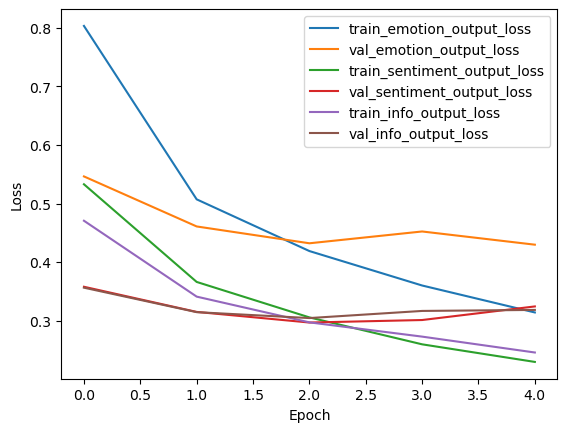

In [35]:
import matplotlib.pyplot as plt

# Plot the loss for each task
for task in ['emotion_output', 'sentiment_output', 'info_output']:
    plt.plot(history.history[f'{task}_loss'], label=f'train_{task}_loss')
    plt.plot(history.history[f'val_{task}_loss'], label=f'val_{task}_loss')

plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


# 5. Metrics

In [36]:
# Make predictions for each task
predicted_emotion = model.predict({'input_ids': input_ids_test, 'attention_mask': attention_mask_test})[0]
predicted_sentiment = model.predict({'input_ids': input_ids_test, 'attention_mask': attention_mask_test})[1]
predicted_info = model.predict({'input_ids': input_ids_test, 'attention_mask': attention_mask_test})[2]

# For each task, get the predicted labels
predicted_labels_emotion = np.argmax(predicted_emotion, axis=1)
predicted_labels_sentiment = np.argmax(predicted_sentiment, axis=1)
predicted_labels_info = np.argmax(predicted_info, axis=1)


167/167 [==============================] - 93s 559ms/step


In [37]:
predicted_labels_emotion = predicted_labels_emotion.tolist()
predicted_labels_emotion = id2label_emotion(predicted_labels_emotion)

predicted_labels_sentiment = predicted_labels_sentiment.tolist()
predicted_labels_sentiment  = id2label_sentiment(predicted_labels_sentiment)

predicted_labels_info = predicted_labels_info.tolist()
predicted_labels_info = id2label_info(predicted_labels_info)

In [38]:
emotion_label_test = emotion_label_test.tolist()
emotion_label_test = id2label_emotion(emotion_label_test)

sentiment_label_test = sentiment_label_test.tolist()
sentiment_label_test  = id2label_sentiment(sentiment_label_test)

info_label_test = info_label_test.tolist()
info_label_test = id2label_info(info_label_test)

## 5.0 Report Classification

In [39]:
# Calculate classification reports for each task
report_emotion = classification_report(emotion_label_test, predicted_labels_emotion)
report_sentiment = classification_report(sentiment_label_test, predicted_labels_sentiment)
report_info = classification_report(info_label_test, predicted_labels_info)

# Print the reports
print("Emotion Classification Report:")
print(report_emotion)

print("\nSentiment Classification Report:")
print(report_sentiment)

print("\nInfo Classification Report:")
print(report_info)

Emotion Classification Report:
              precision    recall  f1-score   support

       AMORE       0.96      0.74      0.84       238
       GIOIA       0.75      0.59      0.66       272
      NEUTRA       0.83      0.91      0.87      1916
       PAURA       0.00      0.00      0.00        14
      RABBIA       0.94      0.93      0.93      1400
    SORPRESA       0.66      0.69      0.67       250
   TRISTEZZA       0.94      0.89      0.91      1247

    accuracy                           0.88      5337
   macro avg       0.73      0.68      0.70      5337
weighted avg       0.88      0.88      0.87      5337


Sentiment Classification Report:
              precision    recall  f1-score   support

         NEG       0.96      0.93      0.95      2491
         NEU       0.72      0.88      0.79      1317
         POS       0.87      0.76      0.81      1529

    accuracy                           0.87      5337
   macro avg       0.85      0.86      0.85      5337
weighted avg

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5.1 Accuracy

In [40]:
accuracy_sentiment = accuracy_score(sentiment_label_test, predicted_labels_sentiment) # (TP+TN)/P+N i.e total number of corrected classified tweet over total number of tweets
accuracy_emotion   = accuracy_score(emotion_label_test, predicted_labels_emotion)
accuracy_info      = accuracy_score(info_label_test, predicted_labels_info)

print("Sentiment accuracy:", accuracy_sentiment)
print("Emotion accuracy:", accuracy_emotion)
print("Info accuracy:", accuracy_info)

Sentiment accuracy: 0.8682780588345512
Emotion accuracy: 0.8752107925801011
Info accuracy: 0.8757729061270376


## 5.2 Precision

In [41]:
precision_sentiment = precision_score(sentiment_label_test, predicted_labels_sentiment,average=None, labels=['NEG','NEU','POS']) # TP/(TP+FP) i.e if predicted a certain class, which is the probability of being really that class?
precision_emotion   = precision_score(emotion_label_test, predicted_labels_emotion,average=None, labels=['TRISTEZZA','GIOIA','AMORE','RABBIA','PAURA','SORPRESA','NEUTRA'])
precision_info      = precision_score(info_label_test, predicted_labels_info,average=None,labels=['INFO','NOINFO','UNPREDICTABLE'])

print("Sentiment precision:", precision_sentiment)
print("Emotion precision:", precision_emotion)
print("Info precision:", precision_info)

Sentiment precision: [0.9641965  0.72465582 0.86761406]
Emotion precision: [0.93839662 0.74883721 0.96195652 0.93682699 0.         0.66153846
 0.83047619]
Info precision: [0.88037068 0.87751371 0.80701754]


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 5.3 Recall

In [42]:
recall_sentiment = recall_score(sentiment_label_test, predicted_labels_sentiment,average=None, labels=['NEG','NEU','POS']) # TP/(TP+FN) i.e the ability of the estimator to predict all the tweets of a given class
recall_emotion   = recall_score(emotion_label_test, predicted_labels_emotion,average=None, labels=['TRISTEZZA','GIOIA','AMORE','RABBIA','PAURA','SORPRESA','NEUTRA'])
recall_info      = recall_score(info_label_test, predicted_labels_info,average=None,labels=['INFO','NOINFO','UNPREDICTABLE'])

print("Sentiment recall:", recall_sentiment)
print("Emotion recall:", recall_emotion)
print("Info recall:", recall_info)

Sentiment recall: [0.92974709 0.87927107 0.75866579]
Emotion recall: [0.89174018 0.59191176 0.74369748 0.93214286 0.         0.688
 0.91022965]
Info recall: [0.9297153  0.93131548 0.359375  ]


# 6. Push to the Hub

In [43]:
from huggingface_hub import notebook_login

notebook_login()

In [44]:
from huggingface_hub import push_to_hub_keras

push_to_hub_keras(model, 'FedeBerto/Griffith')

saved_model.pb:   0%|          | 0.00/6.00M [00:00<?, ?B/s]

fingerprint.pb:   0%|          | 0.00/56.0 [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

variables.data-00000-of-00001:   0%|          | 0.00/439M [00:00<?, ?B/s]

'https://huggingface.co/FedeBerto/Griffith/tree/main/'

In [ ]:
from huggingface_hub import from_pretrained_keras

model = from_pretrained_keras('FedeBerto/Griffith')